In [4]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.linalg import norm

import pickle
#from bunch import bunchify

import cav as cav

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt



In [5]:
from functions import *

/Users/tyler/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']

size_dict = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict[bn] = acts_orig.reshape(-1).shape[0]
    
size_dict_orig = {}
for bn in bn_names:
    acts_orig = get_acts_for_layer_new(bn,this_img)
    size_dict_orig[bn] = acts_orig.shape

In [7]:
model = load_model('v3_model.h5')

In [8]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'


label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

## Load/Generate CAV

In [18]:
target_class_name = 'zebra'
target_class = 'lots_of_zebras'

target_class_name = 'zebra'
concept_p = 'striped_sub_1'
concept_n = 'random500_0'

bn_names = ['mixed9']
layer = bn_names[0]

num_random = 1
split_seed_list = [1]
split_seed = split_seed_list[0]

acts_p,_ = get_acts_for_concept(concept_p,layer)
acts_n,_ = get_acts_for_concept(concept_n,layer)
_,acts_class = get_acts_for_concept(target_class,layer)

x = np.concatenate((acts_p,acts_n))
y = np.concatenate((np.zeros(50),np.ones(50)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=split_seed)

'''
orig_cav = make_orig_cav(x_train,y_train)
orig_score = comp_tcav(target_class_name,orig_cav,acts_class,layer)

marg_seeds = np.empty((100,orig_cav.shape[0]))
for seed in range(100):
    marg_seeds[seed] = make_orig_cav_seed(x_train,y_train,seed)
marg_cav = marg_seeds.mean(axis=0)
marg_score = comp_tcav(target_class_name,marg_cav,acts_class,layer)
'''
x_train_p_list,x_train_n_list =[],[]
for idx,a in enumerate(x_train):
    if y_train[idx] == 1:
        x_train_n_list.append(a)
    else:
        x_train_p_list.append(a)

x_train_p, x_train_n = np.array(x_train_p_list),np.array(x_train_n_list)

mu_p = (x_train_p).mean(axis=0)
mu_n = (x_train_n).mean(axis=0)
cav_params = mu_p - mu_n
mean_score = comp_tcav(target_class_name,cav_params,acts_class,layer)
print(mean_score)
#cav_params = make_log_cav(x_train,y_train)
#log_score = comp_tcav(target_class_name,cav_params,acts_class,layer)
#print(log_score)

0.5933333333333334


In [19]:
#acts_class.shape

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)
pca_c = pca.components_

In [21]:
from sklearn.decomposition import SparsePCA
sPCA = SparsePCA(n_components=2,normalize_components=False,random_state=1)
sPCA.fit(x_train)
pca_c = sPCA.components_

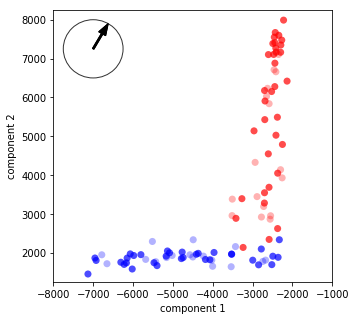

In [37]:
light_blue, light_red = '#b3b8fb', '#f6889f'
fig = plt.figure(figsize=[5,5])

color_train = ['red' if y == 0 else 'blue' for y in y_train]
train_embed = np.dot(x_train,pca_c.T)
plt.scatter(train_embed[:,0], train_embed[:,1], color = color_train, alpha = .7,linewidths=0,s=50)

color_test = ['red' if y == 0 else 'blue' for y in y_test]
test_embed = np.dot(x_test,pca_c.T)
plt.scatter(test_embed[:,0], test_embed[:,1], color = color_test, alpha = .3,linewidths=0,s=50)

plt.xlim([-8000,-1000])
plt.ylim([1250,8250])

x1,x2 = -7000,7250
ax = plt.gca()
radius = 750
circ = plt.Circle((x1,x2), radius=radius, edgecolor='black', facecolor='white',zorder=4,alpha=.8)
ax.add_patch(circ)

c0,c1 =  np.dot(pca_c,cav_params)
arrow_start = [x1,x2]
cav_norm = vec_norm(np.array([c0,c1])) * radius
my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=40,length_includes_head=True,head_width=200,fc='k', ec=None, alpha = 1,zorder=5)
a0 = ax.add_patch(my_arrow)


_,_ = plt.xlabel('component 1'),plt.ylabel('component 2')

#_,_ = plt.xticks([], []),plt.yticks([], [])
#plt.savefig('new_figs/tmp.png',dpi=200,bbox_inches='tight')